In [1]:
%cd ../input/image-unet

/kaggle/input/image-unet


In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/010841.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/010841.png', shape=(), dtype=string)


In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D((n_filters),
                  3,  
                  activation="relu",
                  padding="same",
                  kernel_initializer='he_normal')(inputs)

    conv = Conv2D(n_filters, 
                  3,  
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv)

   
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
    
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
   
    up = Conv2DTranspose(
                 n_filters,    
                 (3,3),   
                 strides=(2,2),
                 padding="same")(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   
                 (3,3),   
                 activation="relu",
                 padding="same",
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 
                 (3,3),  
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(conv)
    
    return conv

In [9]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
  
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)

    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=None) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, 1, padding="same")(conv9)
  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [10]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [11]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [12]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [14]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40


2023-11-13 09:32:00.424761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - 37s 349ms/step - loss: 1.7070 - accuracy: 0.5130
Epoch 2/40
33/33 [==============================] - 5s 148ms/step - loss: 0.7203 - accuracy: 0.8158
Epoch 3/40
33/33 [==============================] - 5s 148ms/step - loss: 0.5611 - accuracy: 0.8427
Epoch 4/40
33/33 [==============================] - 5s 149ms/step - loss: 0.4395 - accuracy: 0.8722
Epoch 5/40
33/33 [==============================] - 5s 150ms/step - loss: 0.3902 - accuracy: 0.8864
Epoch 6/40
33/33 [==============================] - 5s 151ms/step - loss: 0.3414 - accuracy: 0.8972
Epoch 7/40
33/33 [==============================] - 5s 152ms/step - loss: 0.3091 - accuracy: 0.9071
Epoch 8/40
33/33 [==============================] - 5s 152ms/step - loss: 0.2694 - accuracy: 0.9199
Epoch 9/40
33/33 [==============================] - 5s 153ms/step - loss: 0.2575 - accuracy: 0.9232
Epoch 10/40
33/33 [==============================] - 5s 154ms/step - loss: 0.2210 - accuracy: 0.9348
Epoch 11/

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

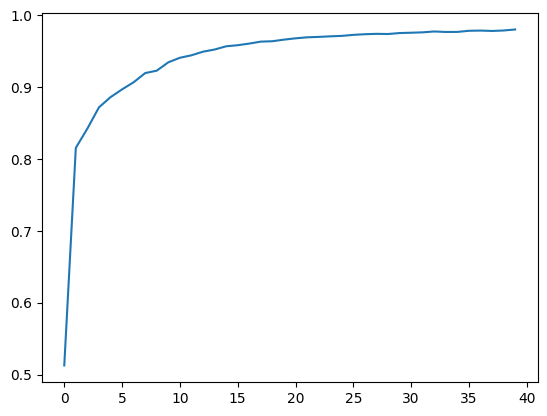

In [16]:
plt.plot(model_history.history["accuracy"])

In [17]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 423ms/step


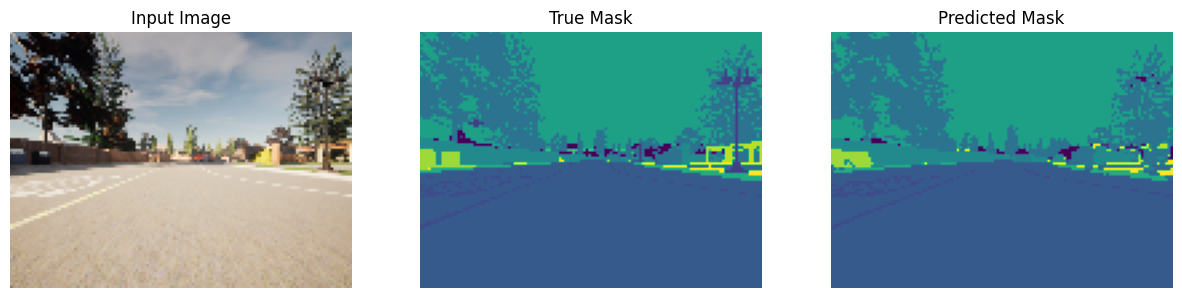

In [18]:
show_predictions(train_dataset, 1)

In [19]:
from tensorflow import keras
save_path = '/kaggle/working'
unet.save(save_path)


In [20]:
cd ../../working


/kaggle/working
